In [ ]:
import importlib
import Universial_Data_Functions
import Correlation_Matrix
import pandas as pd
import numpy as np
from concurrent.futures import ThreadPoolExecutor
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sktime.forecasting.compose import ForecastingPipeline, make_reduction
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.datasets import load_longley
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import LSTM, Dense

#Check if there is connection with the SQL database
if Universial_Data_Functions.Connection_With_DB: 
    data_obj = Universial_Data_Functions.Visualaize_Data(sql_handler= Universial_Data_Functions.cursor,timestamp_begin='\'2024-01-10\'',database_name='822Raw',minutes_amount = 2000000)

    to_get = [
            'AC[2].AH[1].AR[1].ART[1].IV_PV_SCL',
            'AC[2].AH[1].AM[1].ATT[1].IV_PV_SCL',
            'AC[2].AH[1].AS[1].ART[1].IV_PV_SCL',
            'AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL',
            'AC[2].AH[1].AI[1].ATT[1].IV_PV_SCL',
            'AC[2].AH[1].AR[1].ATT[1].IV_PV_SCL',    
            'AC[2].AH[1].AH[1].SHU[1].IV_PV',
            'AC[2].AH[1].AC[1].WCV[1].IV_PV',
            'AC[2].AH[1].AP[1].AHE[1].IV_PV',
            'AC[2].AH[1].AC[1].WTT[1].IV_PV_SCL',        
            'AC[2].AH[1].AC[1].WTT[2].IV_PV_SCL',        
            'AC[2].AH[1].FM[1].FSC[1].IV_PV_SPD'
        ]
    #Dictionary for converting tags to a more readable format
    custom = {
        'AC[2].AH[1].AC[1].WCV[1].IV_PV' : 'Cold water valve (%)',
        'AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL' : 'Supply air temperature (°C)',
        'AC[2].AH[1].AM[1].ATT[1].IV_PV_SCL' : 'Mixing air temperature (°C)',
        'AC[2].AH[1].FM[1].FSC[1].IV_PV_SPD' : 'Supply fan speed (%)',
        'AC[2].AH[1].AI[1].ATT[1].IV_PV_SCL' : 'Intake air temperature (°C)',
        'AC[2].AH[1].AC[1].WTT[1].IV_PV_SCL' : 'Cold water inlet temeprature (°C)',
        'AC[2].AH[1].AC[1].WTT[2].IV_PV_SCL' : 'Cold water outlet temeprature (°C)',
        'AC[2].AH[1].AR[1].ART[1].IV_PV_SCL' : 'Return air humidity (%)',
        'AC[2].AH[1].AH[1].SHU[1].IV_PV':  'Steam humidifier output (%) ',
        'AC[2].AH[1].AS[1].ART[1].IV_PV_SCL': 'Supply air humidity (%)'
    }
    #Create the unfliterd data frame
    data_obj.Create_DF(requests=to_get,fill_zero_room= True,fill_zero_other= True,AH_in_table= False)
    #Mask off broken sensor data
    data_obj.mask_off('AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL',value= 0, minutes= 2)
    #Clear the gaps that are present in the dataframe
    data_obj.shorten_all_gaps(steps = 20,reset_index= True)
    
print(data_obj.df.head())


/home/Digital_Twin/Finished/SQL_Connect.py:325: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mask_Data.loc[:, 'EndTimestamp'] = mask_Data['EndOfBlock'].shift(-1).fillna(False)


            Timestamp  AC[2].AH[1].AR[1].ART[1].IV_PV_SCL  \
0 2024-01-10 01:01:00                                45.0   
1 2024-01-10 01:02:00                                45.0   
2 2024-01-10 01:03:00                                45.0   
3 2024-01-10 01:04:00                                45.0   
4 2024-01-10 01:05:00                                45.0   

   AC[2].AH[1].AS[1].ART[1].IV_PV_SCL  AC[2].AH[1].AH[1].SHU[1].IV_PV  \
0                                47.0                            77.0   
1                                52.0                            77.0   
2                                52.0                            77.0   
3                                45.0                            77.0   
4                                52.0                            77.0   

   AC[2].AH[1].AM[1].ATT[1].IV_PV_SCL  AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL  \
0                                11.6                                18.2   
1                                11.7   

/home/Digital_Twin/Finished/SQL_Connect.py:647: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  data_range = pd.date_range(start= start,periods= len(df_pointer), freq= 'T')


In [135]:
from sklearn.preprocessing import MinMaxScaler
#Noralise the train data X
scaler = MinMaxScaler()
def normalize_with_DT(df):
    #Split the dataframe in datetime columns and numerical columns
    datetime_cols = df.select_dtypes(include=['datetime64']).columns
    numerical_cols = df.select_dtypes(include=['float64','int64']).columns
    #apply the scaler to the numerical columns
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    #Return the combined and transformed dataframe 
    return pd.concat([ df[numerical_cols]], axis=1)

In [ ]:
#For the scaler get the lowest and the highest lowest values
lower_range_valve, upper_range_valve = data_obj.retun_min_max(column= 'AC[2].AH[1].AC[1].WCV[1].IV_PV',df_External= data_obj.df)
lower_range_temp, upper_range_temp = data_obj.retun_min_max(column= 'AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL',df_External= data_obj.df)
#Drop the timestamp from the dataframes
lower_range_valve.drop('Timestamp',axis= 1,inplace= True)
upper_range_valve.drop('Timestamp',axis= 1,inplace= True)

#Drop the supply temeprature
lower_range_valve.drop('AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL',axis= 1,inplace= True)
upper_range_valve.drop('AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL',axis= 1,inplace= True)

#This is a function that converts the data within the dataframe range
def normalize_scale(min,max,input):
    if input >= min and input <= max:
        result = (input-min) / (max-min)
        return result
    elif input < min:
        return 0
    else:
        return 1
low_temp = lower_range_temp['AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL'].values[0]
high_temp = upper_range_temp['AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL'].values[0]

#This is a function that converts the data within the dataframe range
def normalize_scale(min,max,input):
    if input >= min and input <= max:
        result = (input-min) / (max-min)
        return result
    elif input < min:
        return 0
    else:
        return 1

print(low_temp)
Temp_diff = normalize_scale(min = low_temp, max= high_temp , input = 11.2)
print(Temp_diff)

10.200000000000001
0.08196721311475394


In [ ]:
#Convert the timestamp to a dat time varaible 
data_obj.df['Timestamp'] = pd.to_datetime(data_obj.df['Timestamp'])
timestamp = data_obj.df['Timestamp']
# Extract the hour of day and replace the 'Timestamp' column
y = data_obj.df[['AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL', 'Timestamp']]
#Create a train and test set for the Y (supply air temperature )
train_y, test_y =train_test_split(y, test_size=0.2,train_size= 0.8, shuffle= False)
train_y.drop(['Timestamp'],axis = 1, inplace= True)
test_y_2 =  test_y.copy()
test_y.drop(['Timestamp'],axis = 1,inplace= True)
test_y.reset_index(drop= True,inplace= True)

data_obj.df['Timestamp'] = pd.to_datetime(data_obj.df['Timestamp'])

#Normalize the whole dataframe and make a split between the train and the test set
inter_df = normalize_with_DT(data_obj.df)
train, test = train_test_split(inter_df, test_size=0.2,train_size= 0.8, shuffle= False)
test.reset_index(drop= True,inplace= True)
#Replace the scaled Y for the non scaled Y
train.drop('AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL',axis= 1,inplace= True)
train =pd.concat([train,train_y],axis = 1)
print(train_y.head())

   AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL
0                                18.2
1                                18.2
2                                18.2
3                                18.2
4                                18.2


In [ ]:
#Create a object with datapoints
Data_change = []
Data_To_Alter = []
Data_To_Alter.append(Universial_Data_Functions.Data_Add(column= 'AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL', add= 2.0))
Data_To_Alter.append(Universial_Data_Functions.Data_Add(column= 'AC[2].AH[1].AC[1].WCV[1].IV_PV', add= -0.2))
Data_change.append(Data_To_Alter)

Data_To_Alter = []
Data_To_Alter.append(Universial_Data_Functions.Data_Add(column= 'AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL', add= -2.0))
Data_To_Alter.append(Universial_Data_Functions.Data_Add(column= 'AC[2].AH[1].AC[1].WCV[1].IV_PV', add= 0.2))
Data_change.append(Data_To_Alter)

Data_To_Alter = []
Data_To_Alter.append(Universial_Data_Functions.Data_Add(column= 'AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL', add= 4))
Data_To_Alter.append(Universial_Data_Functions.Data_Add(column= 'AC[2].AH[1].AC[1].WCV[1].IV_PV', add= -0.4))
Data_change.append(Data_To_Alter)

Data_To_Alter = []
Data_To_Alter.append(Universial_Data_Functions.Data_Add(column= 'AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL', add= -4))
Data_To_Alter.append(Universial_Data_Functions.Data_Add(column= 'AC[2].AH[1].AC[1].WCV[1].IV_PV', add= 0.4))
Data_change.append(Data_To_Alter)

#Put on False when the normal regression model is trained, and when it it set on True the regression model with the added data is trained
extend = True
if extend == True: 
    train = data_obj.extend_df(start = 0,length= 70000,to_change=Data_change,interpolate_steps= 30,timestamp_begin= '\'2024-01-05\'',df_external=train,df_copy=train,pyramid=True,gaussian= True)



2.0
-0.2
-2.0
0.2
4
-0.4
-4
0.4
Interpolated 30
External
Interpolated 30
External
Interpolated 30
External
Interpolated 30
External
   AC[2].AH[1].AR[1].ART[1].IV_PV_SCL  AC[2].AH[1].AS[1].ART[1].IV_PV_SCL  \
0                            0.389831                            0.305556   
1                            0.389831                            0.375000   
2                            0.389831                            0.375000   
3                            0.389831                            0.277778   
4                            0.389831                            0.375000   

   AC[2].AH[1].AH[1].SHU[1].IV_PV  AC[2].AH[1].AM[1].ATT[1].IV_PV_SCL  \
0                            0.77                            0.232558   
1                            0.77                            0.238372   
2                            0.77                            0.232558   
3                            0.77                            0.232558   
4                            0.77       

/home/Digital_Twin/Finished/SQL_Connect.py:647: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  data_range = pd.date_range(start= start,periods= len(df_pointer), freq= 'T')


In [ ]:
#Create the translation dictinaray from the tags to a more readable text   
custom = {
        'AC[2].AH[1].AC[1].WCV[1].IV_PV' : 'Cold water valve (%)',
        'AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL' : 'Supply air temperature (°C)',
        'AC[2].AH[1].AM[1].ATT[1].IV_PV_SCL' : 'Mixing air temperature (°C)',
        'AC[2].AH[1].FM[1].FSC[1].IV_PV_SPD' : 'Supply fan speed (%)',
        'AC[2].AH[1].AI[1].ATT[1].IV_PV_SCL' : 'Intake air temperature (°C)',
        'AC[2].AH[1].AC[1].WTT[1].IV_PV_SCL' : 'Cold water inlet temeprature (°C)',
        'AC[2].AH[1].AC[1].WTT[2].IV_PV_SCL' : 'Cold water outlet temeprature (°C)',
        'AC[2].AH[1].AR[1].ART[1].IV_PV_SCL' : 'Return air humidity (%)',
        'AC[2].AH[1].AH[1].SHU[1].IV_PV':  'Steam humidifier output (%) ',
        'AC[2].AH[1].AS[1].ART[1].IV_PV_SCL': 'Supply air humidity (%)', 
        'AC[2].AH[1].AR[1].ATT[1].IV_PV_SCL': 'Return air temperature (°C)',
        'AC[2].AH[1].AP[1].AHE[1].IV_PV': 'Preheater output (%)'
}

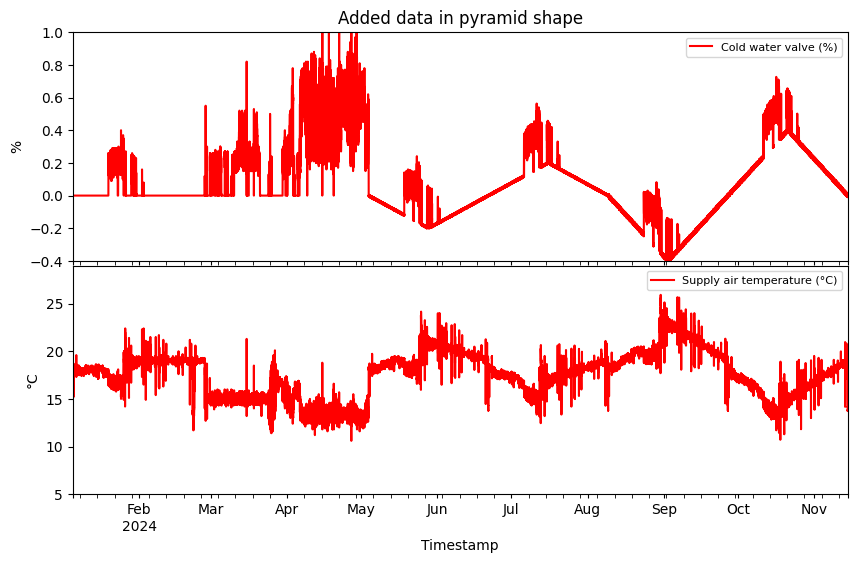

<Figure size 20000x600 with 0 Axes>

<Figure size 1500x8000 with 0 Axes>

/home/Digital_Twin/Finished/SQL_Connect.py:805: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout()  # Adjust layout


In [ ]:
#Set the ranges for the trending
data_obj.lower_range = -0.4
data_obj.upper_range = 1
data_obj.lower_range2 = 5
data_obj.upper_range2 =29
#Set the sub plot amount
data_obj.amount_of_Plots = 2 
#Make a selction for sunb plot 1 and 2
set1 = ['Timestamp','Cold water valve (%)']
set2 = ['Timestamp','Supply air temperature (°C)' ]
#Plot the data
data_obj.Plot_Custom(df_in=train,title= 'Added data in pyramid shape',legend_heigth= -0.4, custom_names=custom,light_mode= True, columns_first_graph= set1, columns_second_graph= set2,y_title_1= '%',y_title_2='°C')


In [ ]:
#Drop the timestamp from the training set
train.drop(['Timestamp'],axis = 1, inplace= True)

453030
        AC[2].AH[1].AR[1].ART[1].IV_PV_SCL  \
453025                            0.457627   
453026                            0.457627   
453027                            0.457627   
453028                            0.457627   
453029                            0.457627   

        AC[2].AH[1].AS[1].ART[1].IV_PV_SCL  AC[2].AH[1].AH[1].SHU[1].IV_PV  \
453025                            0.597222                             0.0   
453026                            0.583333                             0.0   
453027                            0.569444                             0.0   
453028                            0.569444                             0.0   
453029                            0.569444                             0.0   

        AC[2].AH[1].AM[1].ATT[1].IV_PV_SCL  \
453025                            0.290698   
453026                            0.296512   
453027                            0.296512   
453028                            0.296512   
453029           

In [ ]:
#Drop the supply air temperature from the test set (y)
test_x = test.drop('AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL',axis= 1)
#Create the test sets with the lowerd and the upperd cold water valve positions
test_x_Lowered = test_x.copy()
test_x_Upperd = test_x.copy()
test_x_Lowered['AC[2].AH[1].AC[1].WCV[1].IV_PV'] = test_x_Lowered['AC[2].AH[1].AC[1].WCV[1].IV_PV'].apply(lambda x: max(x - 0.3, -1))
test_x_Upperd['AC[2].AH[1].AC[1].WCV[1].IV_PV'] = test_x_Upperd['AC[2].AH[1].AC[1].WCV[1].IV_PV'].apply(lambda x: min(x + 0.3, 1))
test_Com =pd.concat([test_x,test_y],axis = 1)
test_Com_l =pd.concat([test_x_Lowered,test_y],axis = 1)
test_Com_u =pd.concat([test_x_Upperd,test_y],axis = 1)


In [ ]:
#Create a sliding window of the regression model
def create_sliding_window(df, target_col, window_size):
    X, y = [], []
    for i in range(len(df) - window_size):
        X.append(df.iloc[i:i + window_size].drop(columns=[target_col]).values)
        y.append(df.iloc[i + window_size][target_col])
    return np.array(X), np.array(y)
#Create all the sliding windows (1 training and 3 testing sets)
window_train_X, window_train_Y = create_sliding_window(df = train, target_col= 'AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL',window_size= 120)
window_test_X, window_test_Y_np = create_sliding_window(df = test_Com, target_col= 'AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL',window_size= 120)
window_test_X_l, window_test_Y_np_s = create_sliding_window(df = test_Com_l, target_col= 'AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL',window_size= 120)
window_test_X_u, window_test_Y_np_d = create_sliding_window(df = test_Com_u, target_col= 'AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL',window_size= 120)
window_test_Y = pd.DataFrame(window_test_Y_np, columns=['AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL'])



In [ ]:
#Import the librarys for the LSMT model
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense,Dropout
# Clear any previous session
K.clear_session()

In [ ]:
#Get the train window size
print(window_train_X.shape[2])

11


In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(120, 11)))
model.add(Dropout(0.1))  # Add dropout with a rate of 0.2
model.add(LSTM(50))
model.add(Dropout(0.1))  # Add dropout with a rate of 0.2
model.add(Dense(1))
#Compile the LSTM model
model.compile(optimizer='adam', loss='mean_squared_error')



I0000 00:00:1740346088.297903   18709 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6333 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1
/usr/local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
from keras.callbacks import EarlyStopping
train = True
#Switch between training or loading in the weights
if train:
    history =  model.fit(window_train_X, window_train_Y, epochs=100, batch_size=2200)
else:
    model.load_weights("LSTM_norm_5.weights.h5")

Epoch 1/100


I0000 00:00:1740346103.847587   72282 cuda_dnn.cc:529] Loaded cuDNN version 90300


206/206 ━━━━━━━━━━━━━━━━━━━━ 32s 140ms/step - loss: 135.8277
Epoch 2/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 26s 126ms/step - loss: 8.3730
Epoch 3/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 24s 115ms/step - loss: 6.1752
Epoch 4/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 26s 125ms/step - loss: 6.1634
Epoch 5/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 24s 119ms/step - loss: 6.1732
Epoch 6/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 25s 119ms/step - loss: 6.1755
Epoch 7/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 25s 120ms/step - loss: 6.1511
Epoch 8/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 26s 125ms/step - loss: 6.1713
Epoch 9/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 25s 121ms/step - loss: 6.0967
Epoch 10/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 25s 121ms/step - loss: 5.7536
Epoch 11/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 25s 121ms/step - loss: 3.5212
Epoch 12/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 24s 117ms/step - loss: 1.3713
Epoch 13/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 24s 116ms/step - loss: 1.1371
Epoch 14/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 24s 115ms/step - loss: 1.0475
Epoch 15/10

In [ ]:
#het the loss value (MSE)
loss = model.evaluate(window_test_X, window_test_Y)

1348/1348 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.1078


In [ ]:
test_y_plot = pd.concat([window_test_Y,timestamp],axis= 1)


In [ ]:
#Mak predictions with the LSTM model
y_pred = model.predict(window_test_X)
y_pred_l = model.predict(window_test_X_l)
y_pred_u= model.predict(window_test_X_u)


1348/1348 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step


In [151]:
test_y_2.reset_index(drop= True,inplace= True)

In [ ]:
#Plot the predictions
data_obj.lower_range = 10
data_obj.upper_range = 18
y_preddf = pd.DataFrame(y_pred,columns=['Predicited supply air temperature (°C)'])
y_preddf_Less = pd.DataFrame(y_pred_l,columns=['Predicited supply air temperature, cold water valve -30% (°C)'])
y_preddf_More = pd.DataFrame(y_pred_u,columns=['Predicited supply air temperature, cold water valve +30% (°C)'])
data_obj.amount_of_Plots = 1 
df_result = pd.concat([test_y_2,y_preddf,y_preddf_Less,y_preddf_More],axis = 1)
data_obj.Plot_Custom(df_in=df_result,title='LSTM model increase/decrease valve position',custom_names=custom,light_mode=True,legend_heigth= -0.2,y_title_1= '°C')

In [ ]:
#Save the trained model to a file
model.save_weights("LSTM_norm_5.weights.h5")